## UGST4167 - Introduction to Bayesian Statistics
## Final Project: Bayesian Methods in Volatility Modeling in Finance
### By: Chorobek Sheranov
### 11.12.2023

In this project, we will delve into one of the applications of Bayesian Statistics within Finance, particulraly in volatility modeling.

Volatility measures the degree of variation in the price of financial instruments over time. It reflects the pace and magnitude of price fluctuations.

Why it matters:
- Risk Management: Volatility helps investors gauge the potential risk associated with a financial asset.
- Market Conditions: High volatility may indicate uncertain market conditions, while low volatility suggests stability.
- Investment Strategies: Traders often adjust their strategies based on the level of volatility in the market.
- Volatility Trading: Exploit discrepancies between forecasted volatility and implied volatility. If forecasted volatility is significantly different from implied volatility, it may create arbitrage opportunities.
- Option Pricing: Volatility is a key input in options pricing models like the Black-Scholes Model.

Volatility modeling is crucial for assessing and managing financial risk.

We aim to apply Bayesian Inference in estimating parameters of two well-renowned volatility modeling equations: GARCH (1, 1) and Stochastic Volatility for forecasting the weekly volatility of the S&P 500.

First, we train and fit the models on the historical data from 2013-2018. Next, we assess their performance on the 2019-now, 11.12.2023 period. The backtesting period includes growth events as well as the covid crisis, representing a broader set of possibilities in financial markets. Hence, we believe that backtesting can provide some insights on strenghts and shortcomings of each model when handling various market conditions.

In [2]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import stan
import arviz as az
import yfinance as yf
import seaborn as sns

In [3]:
#downloading train data
ticker_symbol = "IVV"
start_date = "2013-01-01"
end_date = "2017-12-31"

# Fetch daily data from Yahoo Finance
ivv_data = yf.download(ticker_symbol, start=start_date, end=end_date)

# Extract the adjusted closing prices
daily_prices = ivv_data['Adj Close']

# Resample to weekly frequency
weekly_prices = daily_prices.resample('W-Fri').ffill()

# Calculate weekly returns (we need them as parameters for volatility models)
weekly_returns = weekly_prices.pct_change()

weekly_returns = weekly_returns.dropna()


[*********************100%%**********************]  1 of 1 completed


In [4]:
#actual volatilities for the train data, our target variable

ivv_data['Daily_Return'] = ivv_data['Adj Close'].pct_change()

# Resample to weekly frequency and calculate weekly standard deviation
weekly_volatility_actual = ivv_data['Daily_Return'].resample('W-Fri').std()

# Drop NaN values
weekly_volatility_actual = weekly_volatility_actual.dropna()
weekly_volatility_actual = np.array(weekly_volatility_actual)

## Model 1: Generalized Autoregressive Conditional Heteroscedasticity(GARCH(1, 1)) Model:

$σ_t^2 = α_0 + α_1a_{t-1}^2 + β_1σ_{t-1}^2$ 

- $σ_t^2$: Conditional variance at time t.
- $a_{t-1}^2$: Squared previous difference in return from the mean at time t - 1.
- $α_0, α_1, β_1$: Model coefficients.

Widely used in modeling and forecasting financial market
volatility.

GARCH models excel in modeling time-varying
volatility, especially during volatility clustering. Versatile across
market conditions, but caution needed with non-stationary data
and extreme events.

Usually the parameters of the autoregressive function are optimized based on Maximum Likelihood Estimation, but if having limited data or one wants to incorporate prior beliefs, posterior distributions are computed for the parameters based on financial returns data. In other words, we will be doing Bayesian Inference.

For GARCH (1, 1), priors are non to weakly informative. Since we have enough data, we let the likelihood to pull all the effect and in practice it is done so as well. 

Priors:

- mu ~ normal(0, 10);           // Prior for mean parameter
- alpha0 ~ cauchy(0, 5);        // Prior for alpha0
- alpha1 ~ beta(2, 2);           // Prior for alpha1 (beta distribution ensures [0, 1])
- beta1 ~ uniform(0, 1);         // Prior for beta1 (uniform distribution ensures [0, 1])

Volatilities are generally small quantiles, it is nearly impossible for it to obtain a value over 1. These priors are generally used in modeling all kinds of volatilities, they are not informative but meaningful as their types of distributions usually do correspond to the distributions of parameters.

In [5]:
#stan code for the garch (1,1)
garch_1_1 = """
    data {
      int<lower=0> T;
      array[T] real r;
      real<lower=0> sigma1;
    }
    parameters {
      real mu;
      real<lower=0> alpha0;
      real<lower=0, upper=1> alpha1;
      real<lower=0, upper=(1-alpha1)> beta1;
    }
    transformed parameters {
      array[T] real<lower=0> sigma;
      sigma[1] = sigma1;
      for (t in 2:T) {
        sigma[t] = sqrt(alpha0
                        + alpha1 * pow(r[t - 1] - mu, 2)
                        + beta1 * pow(sigma[t - 1], 2));
      }
    }
    model {
      // Priors
      mu ~ normal(0, 10);           // Prior for mean parameter
      alpha0 ~ cauchy(0, 5);        // Prior for alpha0
      alpha1 ~ beta(2, 2);           // Prior for alpha1 (beta distribution ensures [0, 1])
      beta1 ~ uniform(0, 1);         // Prior for beta1 (uniform distribution ensures [0, 1])

      r ~ normal(mu, sigma);
    }

    generated quantities {   //log likelihood for loo-cv
      vector[T] log_lik;

      for (t in 1:T) {
        log_lik[t] = normal_lpdf(r[t] | mu, sigma[t]);
      }
    }
"""

In [6]:
data = {
    'T': len(weekly_returns),
    'r': np.array(weekly_returns),
    'sigma1': weekly_volatility_actual[0]   #specify prior standard deviation
}

In [7]:
import nest_asyncio
nest_asyncio.apply()

In [8]:
# build the model and sample from the posterior
post_garch= stan.build(garch_1_1, data=data, random_seed=42)
fit = post_garch.sample(num_samples=10000, num_warmup=1000)

Building...



Building: found in cache, done.Sampling:   0%
Sampling:   0% (1/44000)
Sampling:   0% (2/44000)
Sampling:   0% (101/44000)
Sampling:   0% (201/44000)
Sampling:   1% (301/44000)
Sampling:   1% (400/44000)
Sampling:   1% (500/44000)
Sampling:   1% (600/44000)
Sampling:   2% (700/44000)
Sampling:   2% (800/44000)
Sampling:   2% (900/44000)
Sampling:   2% (1000/44000)
Sampling:   2% (1100/44000)
Sampling:   3% (1200/44000)
Sampling:   3% (1300/44000)
Sampling:   3% (1401/44000)
Sampling:   4% (1801/44000)
Sampling:   5% (2100/44000)
Sampling:   6% (2500/44000)
Sampling:   7% (3000/44000)
Sampling:   8% (3500/44000)
Sampling:   9% (3900/44000)
Sampling:  10% (4400/44000)
Sampling:  30% (13200/44000)
Sampling:  32% (14000/44000)
Sampling:  32% (14001/44000)
Sampling:  52% (22801/44000)
Sampling:  75% (33001/44000)
Sampling: 100% (44000/44000)
Sampling: 100% (44000/44000), done.
Messages received during sampling:
  Gradient evaluation took 0.00029 seconds
  1000 transitions using 10 leapfrog

In [9]:
az_data = az.from_pystan(fit)
az.summary(az_data, var_names = ['mu', 'alpha0', 'alpha1', 'beta1' ])

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,0.003,0.001,0.002,0.005,0.000,0.0,44505.0,29643.0,1.0
alpha0,0.000,0.000,0.000,0.000,0.000,0.0,12397.0,14215.0,1.0
alpha1,0.154,0.051,0.064,0.249,0.000,0.0,15595.0,16883.0,1.0
beta1,0.778,0.069,0.653,0.899,0.001,0.0,13391.0,14543.0,1.0


R_hat value of 1 for all dimensions of our posterior indicate successful and convergent sampling.

Posterior distributions and samples from all parameters of the GARCH (1,1):

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>]],
      dtype=object)

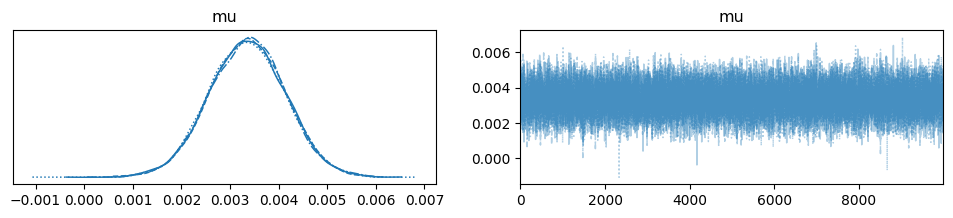

In [10]:
# Check convergence diagnostics
az.plot_trace(az_data, var_names = ['mu'])

array([[<Axes: title={'center': 'alpha0'}>,
        <Axes: title={'center': 'alpha0'}>]], dtype=object)

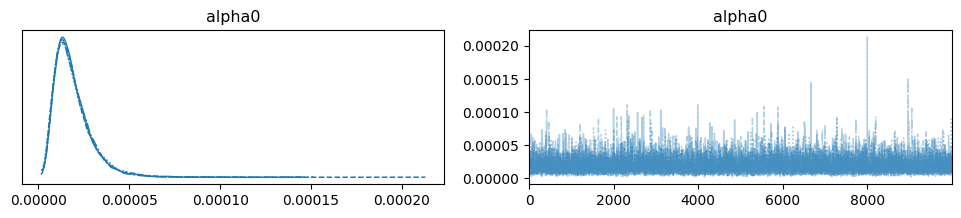

In [11]:
az.plot_trace(az_data, var_names = ['alpha0'])

array([[<Axes: title={'center': 'alpha1'}>,
        <Axes: title={'center': 'alpha1'}>]], dtype=object)

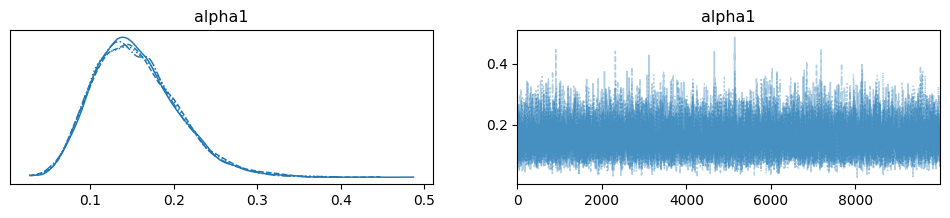

In [12]:
az.plot_trace(az_data, var_names = ['alpha1'])


array([[<Axes: title={'center': 'beta1'}>,
        <Axes: title={'center': 'beta1'}>]], dtype=object)

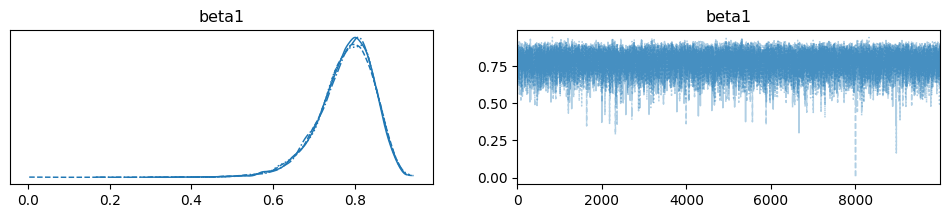

In [13]:
az.plot_trace(az_data, var_names = ['beta1'])

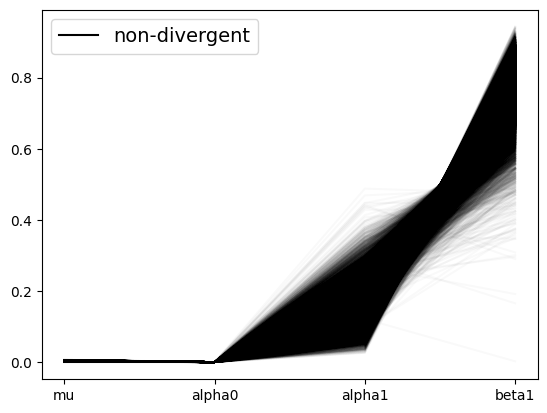

In [14]:
# Check for divergences
az.plot_parallel(az_data, var_names=['mu', 'alpha0', 'alpha1', 'beta1'])
plt.show()

Based on the plot above, we can conclude that sampling was implemented successfully with no divergencies.

Next, we obtain the expected values of our parameters from the posterior by simply taking means of samples as approximates.

In [15]:
mu, alpha0, alpha1, beta1 = fit['mu'].mean(), fit['alpha0'].mean(), fit['alpha1'].mean(), fit['beta1'].mean()   #obtain posterior estimates

In [16]:
T = len(weekly_volatility_actual)
volatility = np.zeros(T)
sigma_t = weekly_volatility_actual[0]

volatility[0] = sigma_t
for t in range(1, T):
    # GARCH(1,1) volatility equation
    sigma_t = np.sqrt(alpha0 + alpha1 * (weekly_returns.iloc[t - 1] - mu)**2 + beta1 * sigma_t**2)

    # Store the predicted volatility for the current week
    volatility[t] = sigma_t

<ipython-input-17-ae85820fd356>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


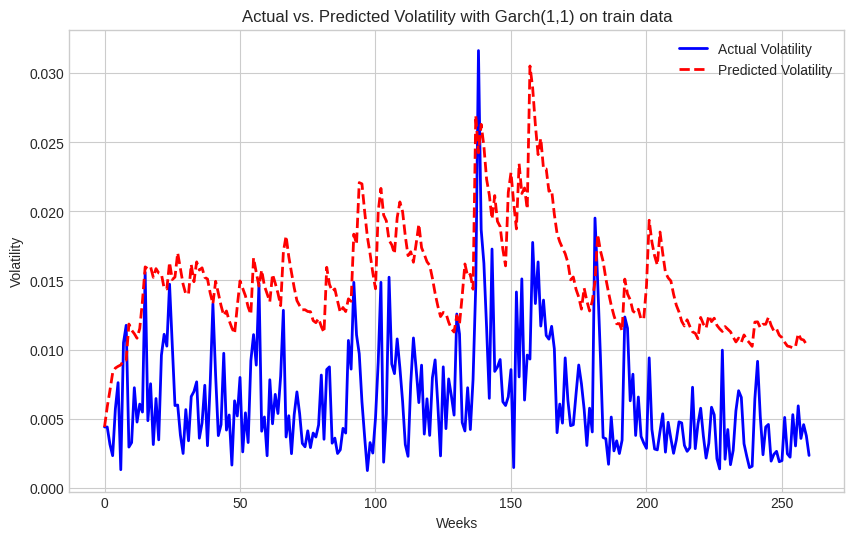

In [17]:
plt.style.use('seaborn-whitegrid')

# Create a line plot
plt.figure(figsize=(10, 6))

# Plot actual volatility in blue with a solid line
plt.plot(weekly_volatility_actual, label='Actual Volatility', color='blue', linewidth=2, linestyle='-')

# Plot predicted volatility in red with a dashed line
plt.plot(volatility, label='Predicted Volatility', color='red', linewidth=2, linestyle='--')

# Customize the plot
plt.title('Actual vs. Predicted Volatility with Garch(1,1) on train data')
plt.xlabel('Weeks')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [57]:
mse_garch_train = np.mean((weekly_volatility_actual - volatility)**2)   #see the mse
print(f"Mean Squared Error (MSE): {mse_garch_train}")

Mean Squared Error (MSE): 8.663235231140369e-05


While general trends are captured, we can definitely see the stationarity of the GARCH (1,1) model. On around week 40, there is a spike in volatility, and the model seems to maintain higher estimates after the period.

### Predictive Performance on Test data for the GARCH (1,1)

In [19]:
#obtain target volatility data for the test period
# Define the date range
# Fetch daily data from Yahoo Finance
ivv_data = yf.download(ticker_symbol, start='2017-12-31')

# Extract the adjusted closing prices
daily_prices = ivv_data['Adj Close']

# Resample to weekly frequency and calculate returns
weekly_returns_test = daily_prices.resample('W-Fri').ffill().pct_change()

# Drop the first row (NaN due to the percentage change)
weekly_returns_test = weekly_returns_test.dropna()


[*********************100%%**********************]  1 of 1 completed


In [20]:
#actual volatilities for the test data

ivv_data['Daily_Return'] = ivv_data['Adj Close'].pct_change()

# Resample to monthly frequency and calculate monthly standard deviation
weekly_volatility_test = ivv_data['Daily_Return'].resample('W-Fri').std()

# Drop NaN values
weekly_volatility_test = weekly_volatility_test.dropna()
weekly_volatility_test = np.array(weekly_volatility_test)

In [60]:
# forecast volatilites for the test set by leveraging obtained estimates
T = len(weekly_volatility_test)
volatility_pred = np.zeros(T)
sigma_t = weekly_volatility_test[0]

volatility_pred[0] = sigma_t
for t in range(1, T):
    # GARCH(1,1) volatility equation
    sigma_t = np.sqrt(alpha0 + alpha1 * (weekly_returns_test.iloc[t - 1] - mu)**2 + beta1 * sigma_t**2)

    # Store the predicted volatility for the current week
    volatility_pred[t] = sigma_t

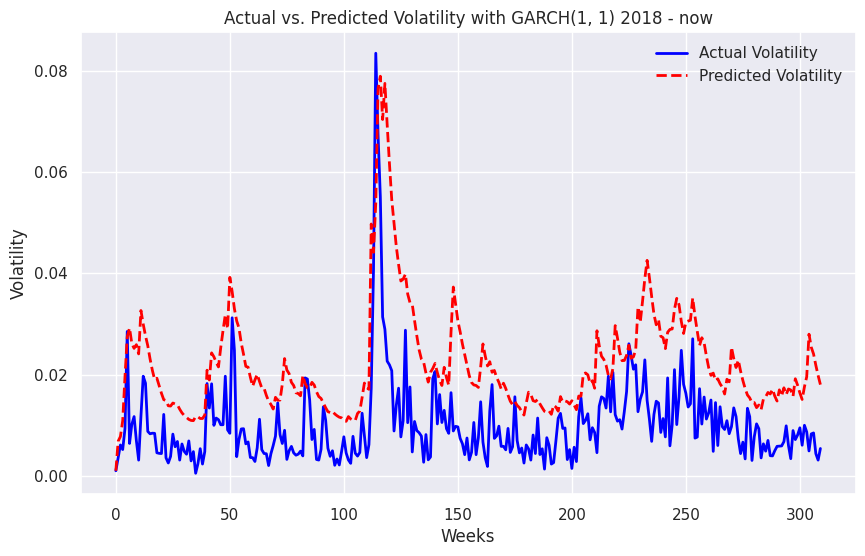

In [61]:
# Set seaborn style
sns.set(style='darkgrid', palette='husl')

# Create a line plot
plt.figure(figsize=(10, 6))

plt.plot(weekly_volatility_test, label='Actual Volatility', color='blue', linewidth=2, linestyle='-')

# Plot predicted volatility in red with a dashed line
plt.plot(volatility_pred, label='Predicted Volatility', color='red', linewidth=2, linestyle='--')

# Customize the plot
plt.title('Actual vs. Predicted Volatility with GARCH(1, 1) 2018 - now')
plt.xlabel('Weeks')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

We see, the fit is pretty good. The Garch (1,1) model was able to capture the covid period spikes in volatility pretty well. Given the stationarity and conditional dependence of future volatilities to the previous ones, we can say that a perk of the model is reacting quickly to vast changes in market conditions.

In [62]:
mse_garch_test = np.mean((weekly_volatility_test - volatility_pred)**2)
print(f"Mean Squared Error (MSE): {mse_garch_test}")

Mean Squared Error (MSE): 0.00020700730745898502


### Model 2: Stochastic Volatility Model:

Equations and parameter dependencies:
$$
y_t = \epsilon_t \exp\left(\frac{h_t}{2}\right) \\
h_{t+1} = \mu + \phi(h_t - \mu) + \delta_t \sigma \\
h_1 \sim \mathcal{N}\left(\mu, \frac{\sigma}{\sqrt{1-\phi^2}}\right) \\
\epsilon_t \sim \mathcal{N}(0, 1) \\
\delta_t \sim \mathcal{N}(0, 1)
$$
Sampling distributions:
$$
y_t \sim \mathcal{N}(0, \exp(h_t/2)) \\
h_t \sim \mathcal{N}(\mu + \phi(h_{t-1} - \mu), \sigma)
$$

Where:
$
y_t: \text{Mean-corrected returns on the underlying asset} \\
h_t: \text{Log volatility at time } t \\
\mu: \text{Mean log volatility} \\
\phi: \text{Persistence of the volatility term} \\
\epsilon_t: \text{White-noise shock on asset return at time } t \\
\delta_t: \text{Shock on volatility at time } t
$



Stochastic Volatility models allow for continuous, smooth
changes in volatility and are generally more flexible. 

The SV model in general is more complex than GARCH, and parameters have more skewed with long tailed distributions which are hard to sample from.
For Stochastic Volatility model, we used informative priors as having uninformative priors led to a slow convergence of MCMC simulations and very low ESS in proportion to number of iterations. SV models and their parameters have more complex distributions, so when having to train on a relatively long interval data, PyStan struggles in sampling. Therefore, we optimized parameters based on the small time interval data prior to the train data to obtain estimates for parameters. Then, we used relevant higher standard deviations for priors to not introduce bias.

This technique has led to much better performance of MCMC sampling and convergence.

We proceeded with intermediate informative priors, which are based on parameter estimates of the SV model trained on 2010-2013 data (3 prior years to the start date of original model).

      mean	       sd	   hdi_3%	hdi_97%
- mu	-8.140	0.461	  -9.019	-7.278
- phi	 0.885	0.081	   0.749	0.996	
- sigma 0.410	0.142	   0.165	0.675	

Given above are the estimates of parameters from the 2010-2013 data SV model. ESS was fine as we have had twice as less observations than in the original model. Based on these estimates, we have defined the following informative priors:

- mu (Mean Log Volatility): normal(-8.1, 2), Centered around the previous estimate of -8.1 with a wider standard deviation of 2.

- phi (Persistence of Volatility): normal(0.885, 0.5), Centered around the previous estimate of 0.885 with a wider standard deviation of 0.5.

We decided to not change the distribution of sigma as the posterior was not complex, and ESS was good.

In [28]:
sv_model = """
    data {
      int<lower=0> T;   // # time points (equally spaced)
      vector[T] y;      // mean corrected return at time t
    }
    parameters {
      real mu;                     // mean log volatility
      real<lower=-1, upper=1> phi; // persistence of volatility
      real<lower=0> sigma;         // white noise shock scale
      vector[T] h_std;             // standardized log volatility at time t
    }
    transformed parameters {
      vector[T] h = h_std * sigma;  // now h ~ normal(0, sigma)
      h[1] /= sqrt(1 - phi * phi);  // rescale h[1]
      h += mu;
      for (t in 2:T) {
        h[t] += phi * (h[t - 1] - mu);
      }
    }
    model {
      phi ~ normal(0.885, 0.5);    //priors
      sigma ~ cauchy(0, 5);
      mu ~ normal(-8.1, 2);
      h_std ~ std_normal();  // vectorized standard normal sampling
      y ~ normal(0, exp(h / 2));
    }
    generated quantities {
      vector[T] log_lik;

      for (t in 1:T) {
        // Add a small constant to the denominator to avoid zero scale or to regularize
        real scale = exp(h[t] / 2) + 1e-6;
        log_lik[t] = normal_lpdf(y[t] | 0, scale);
      }
    }

"""


In [29]:
data_1 = {
    'T': len(weekly_returns),
    'y': np.array(weekly_returns.mean()-weekly_returns)
}

In [35]:
#obtain the postrior samples
post_sv = stan.build(sv_model, data=data_1, random_seed=42)  
fit_1 = post_sv.sample(num_samples = 15000, num_warmup=1000)

Building...



Building: found in cache, done.Sampling:   0%
Sampling:   0% (1/64000)
Sampling:   0% (2/64000)
Sampling:   0% (101/64000)
Sampling:   0% (200/64000)
Sampling:   0% (300/64000)
Sampling:   1% (400/64000)
Sampling:   1% (500/64000)
Sampling:   1% (600/64000)
Sampling:   1% (700/64000)
Sampling:   1% (900/64000)
Sampling:   2% (1000/64000)
Sampling:   2% (1100/64000)
Sampling:   2% (1200/64000)
Sampling:   2% (1300/64000)
Sampling:   2% (1400/64000)
Sampling:   2% (1600/64000)
Sampling:  26% (16900/64000)
Sampling:  50% (32000/64000)
Sampling:  75% (48000/64000)
Sampling: 100% (64000/64000)
Sampling: 100% (64000/64000), done.
Messages received during sampling:
  Gradient evaluation took 9.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.91 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Scale parameter[1] is 0, bu

The error is about scale exp(h/2) in computation of log likelihood tending to 0. It is due to overflow errors associated with particularly exponents and working with them. But there is nothing wrong with the model because volatility can be relatively small that overflow errors make it 0.


In [36]:
az_data1 = az.from_pystan(fit_1)

az.summary(az_data1, var_names = ['mu', 'phi', 'sigma'])


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,-8.809,0.431,-9.692,-8.038,0.011,0.008,3224.0,1371.0,1.0
phi,0.932,0.062,0.825,0.998,0.001,0.000,4503.0,1761.0,1.0
sigma,0.277,0.112,0.096,0.486,0.001,0.001,8865.0,13497.0,1.0


We are employing 15000 iterations for the Stochastic Volatility model, but we can definitely see that sampling is much more challenging than with GARCH given the ESS scores we get.

array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>]],
      dtype=object)

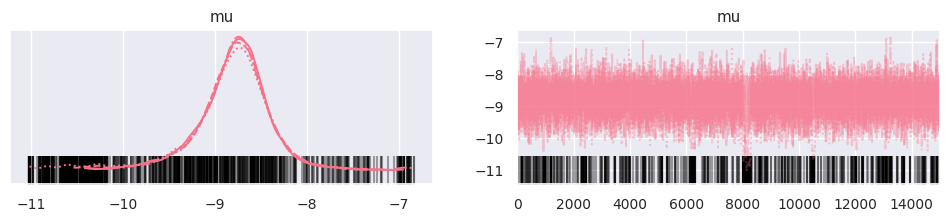

In [37]:
# Check convergence diagnostics
az.plot_trace(az_data1, var_names = ['mu'])

array([[<Axes: title={'center': 'phi'}>, <Axes: title={'center': 'phi'}>]],
      dtype=object)

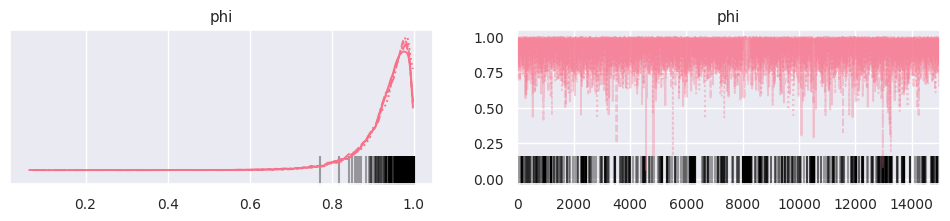

In [39]:
az.plot_trace(az_data1, var_names = ['phi'])

array([[<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

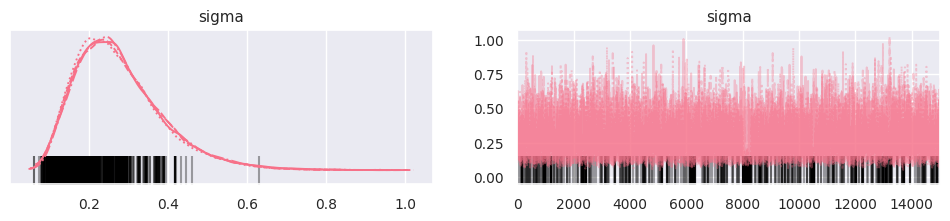

In [40]:
az.plot_trace(az_data1, var_names = ['sigma'])

Given above distributions are, as we see, heavy tailed, skewed and more complex. There are many divergent or not accepted samples due to that fact.

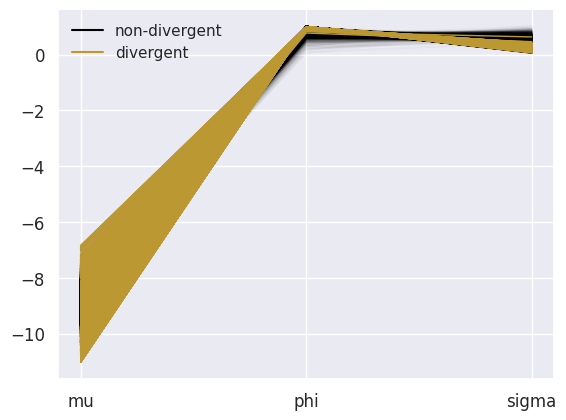

In [41]:
# Check for divergences
az.plot_parallel(az_data1, var_names=['mu', 'phi', 'sigma'])
plt.show()

### Assessment and fit on the train data for the Stochastic Volatility model:

In [42]:
vols = [fit_1['h'][n].mean() for n in range(len(weekly_returns))]

In [43]:
vols = np.array(vols)
vols = np.exp(vols/2)

<ipython-input-44-dcb40bbb8ee6>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


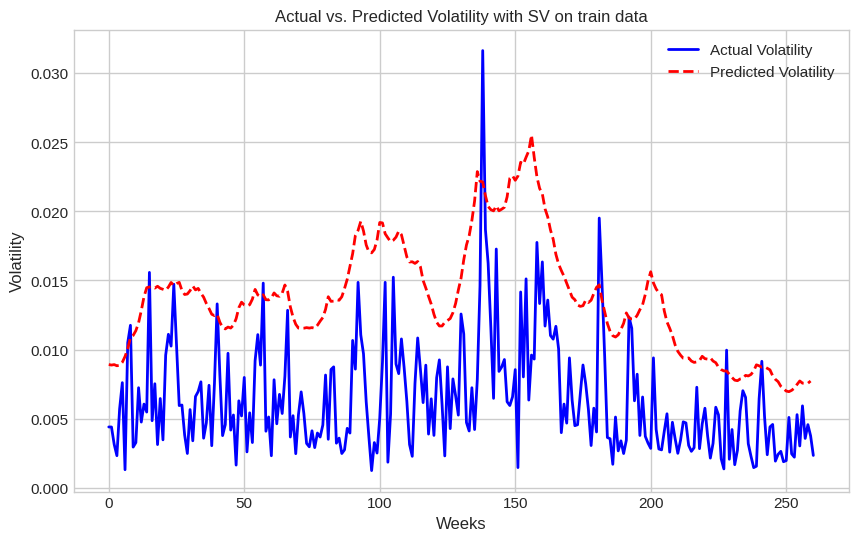

In [44]:
plt.style.use('seaborn-whitegrid')

# Create a line plot
plt.figure(figsize=(10, 6))

# Plot actual volatility in blue with a solid line
plt.plot(weekly_volatility_actual, label='Actual Volatility', color='blue', linewidth=2, linestyle='-')

# Plot predicted volatility in red with a dashed line
plt.plot(vols, label='Predicted Volatility', color='red', linewidth=2, linestyle='--')

# Customize the plot
plt.title('Actual vs. Predicted Volatility with SV on train data')
plt.xlabel('Weeks')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

Again, while it is capturing main trends, volatilites are definitely being overestimated.

In [53]:
mse_sv_train = np.mean((weekly_volatility_actual[1:] - vols)**2)   #see the mse
print(f"Mean Squared Error (MSE): {mse_sv_train}")

Mean Squared Error (MSE): 6.832147407072107e-05


### Predictive Performance on Test Data for the Stochastic Volatility model

In [54]:
mu_sv, phi_sv, sigma_sv = fit_1['mu'].mean(), fit_1['phi'].mean(), fit_1['sigma'].mean()   #parameters for sv model

In [55]:
#predictive performance on unseen data
T = len(weekly_returns_test)

h = np.zeros(T)
h[0] = np.random.normal(mu_sv, sigma_sv / np.sqrt(1 - phi_sv ** 2))

# Perform volatility prediction for each week
for t in range(1, T):
    # SV model volatility equation
    h[t] = mu_sv + phi_sv * (h[t - 1] - mu_sv) + np.random.normal(0, sigma_sv)

volatility_pred = np.exp(h / 2)


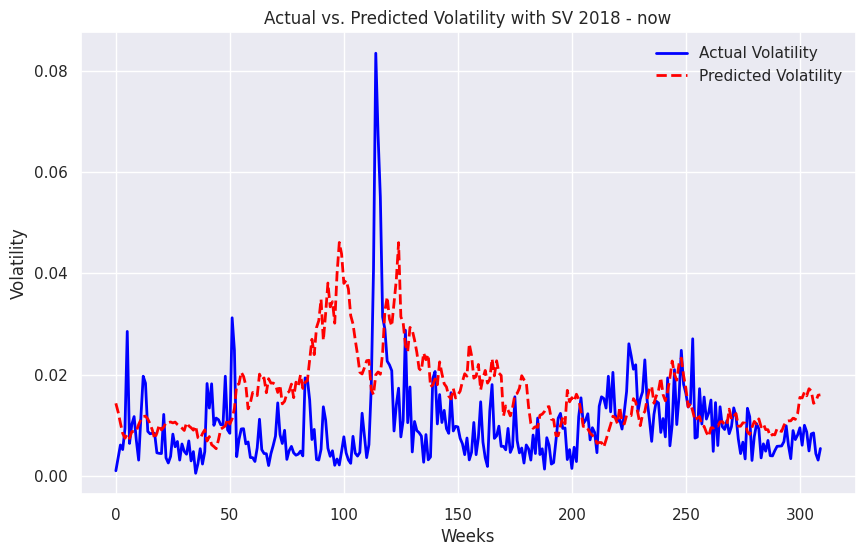

In [56]:

# Set seaborn style
sns.set(style='darkgrid', palette='husl')

# Create a line plot
plt.figure(figsize=(10, 6))

plt.plot(weekly_volatility_test, label='Actual Volatility', color='blue', linewidth=2, linestyle='-')

# Plot predicted volatility in red with a dashed line
plt.plot(volatility_pred, label='Predicted Volatility', color='red', linewidth=2, linestyle='--')

# Customize the plot
plt.title('Actual vs. Predicted Volatility with SV 2018 - now')
plt.xlabel('Weeks')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

Stochastic volatility model performed quite well starting from week 150, but was unable to capture accurately the covid spike unlike GARCH. GARCH, on the other hand, did good on the spike but was not the best in following trends starting from week 150.

GARCH is autoregressive, more dependent on previous values, therefore, after the spike, garch will spend some time at higher volatility levels unlike SV which is flexible and not much dependent on its previous values.

In [59]:
mse_sv_test = np.mean((weekly_volatility_test - volatility_pred)**2)   #see the mse
print(f"Mean Squared Error (MSE): {mse_sv_test}")

Mean Squared Error (MSE): 0.00016143499418462055


# Model Comparison

In [63]:
# Compile the inference data using ArviZ
idata_garch = az.from_pystan(fit)
idata_sv = az.from_pystan(fit_1)

# Perform LOO-CV and calculate the model comparison
loo_garch = az.loo(idata_garch)
loo_sv = az.loo(idata_sv)

# Compare the models using LOO-CV
az.compare({"GARCH": idata_garch, "SV": idata_sv}, ic="loo")

/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
SV,0,745.612191,21.643159,0.000000,0.998913,13.557279,0.000000,True,log
GARCH,1,735.597810,4.288769,10.014381,0.001087,15.217783,5.388008,False,log


SV is ranked higher, however, estimates are not the most reliable due to some high pareto k values for SV.

In [64]:
# Access the Pareto k values
pareto_k_garch = loo_garch.pareto_k

# You can also summarize the Pareto k values
print("\nSummary of Pareto k values for Garch(1,1):")
print(az.summary({"k": pareto_k_garch}))

Shape validation failed: input_shape: (1, 260), minimum_shape: (chains=2, draws=4)



Summary of Pareto k values for Garch(1,1):
    mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
k -0.013  0.084  -0.187    0.119      0.005    0.007     198.0      25.0   

   r_hat  
k    NaN  


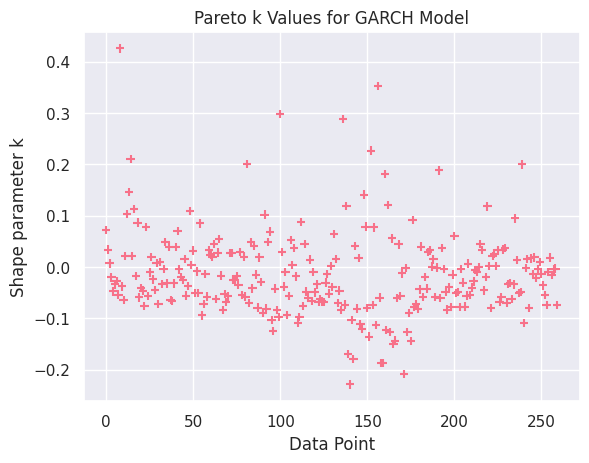

In [65]:
# Plot the histogram using az.plot_khat
ax = az.plot_khat(pareto_k_garch)

# Add a label indicating that it is for GARCH
ax.set_title('Pareto k Values for GARCH Model')

# Show the plot
plt.show()

Everything is fine with GARCH.

In [66]:
# Access the Pareto k values for Sv model
pareto_k_sv = loo_sv.pareto_k

# You can also summarize the Pareto k values
print("\nSummary of Pareto k values for SV:")
print(az.summary({"k": pareto_k_sv}))

Shape validation failed: input_shape: (1, 260), minimum_shape: (chains=2, draws=4)



Summary of Pareto k values for SV:
    mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
k  0.244  0.19     0.0    0.575      0.009    0.006     333.0     185.0    NaN


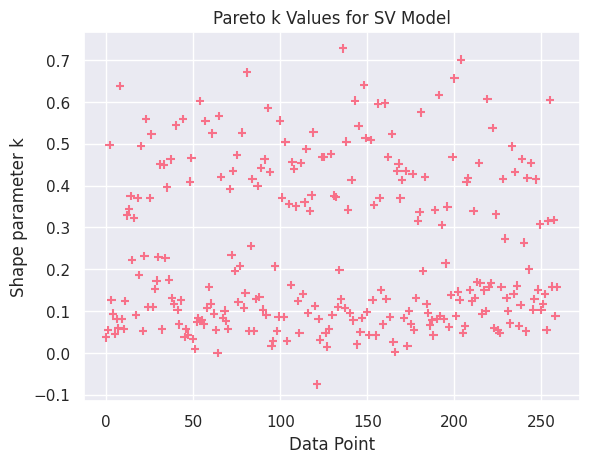

In [67]:
# Plot the histogram using az.plot_khat
ax = az.plot_khat(pareto_k_sv)

# Add a label indicating that it is for SV
ax.set_title('Pareto k Values for SV Model')

# Show the plot
plt.show()

While we see 2 points above 0.7 for SV, the LOO-CV is still valid test, but not as reliable as it could be.

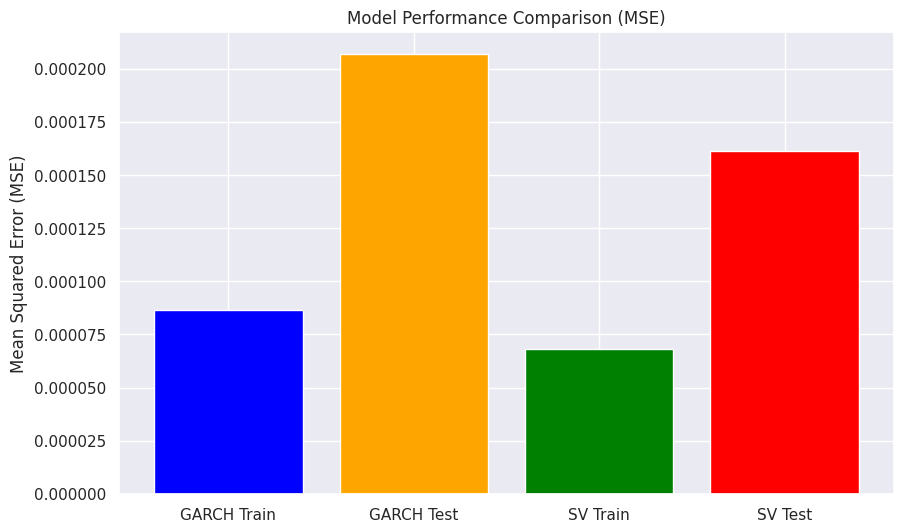

In [68]:
mse_values = {
    'GARCH Train': 8.663235231140369e-05,
    'GARCH Test': 0.00020700730745898502,
    'SV Train': 6.832147407072107e-05,
    'SV Test': 0.00016143499418462055,
}

# Create a DataFrame
mse_df = pd.DataFrame(list(mse_values.items()), columns=['Model', 'MSE'])

# Plot the MSE values using a bar plot
plt.figure(figsize=(10, 6))
plt.bar(mse_df['Model'], mse_df['MSE'], color=['blue', 'orange', 'green', 'red'])
plt.title('Model Performance Comparison (MSE)')
plt.ylabel('Mean Squared Error (MSE)')
plt.show()

Mean Squared errors is also a comparison technique in volatility modeling. As we see, SV has lower MSE values for both train and test data predictive performance, thus it would be more favored compared to GARCH (1, 1). 

However, we cannot just say that SV is better than GARCH, just due to SV being favored in both LOO-CV and MSE comparison. If, for instance, we were interested in the ability to determine huge spikes, GARCH would be a better choice.

# Sensitivity analysis with respect to prior choices

Since we are training on 6 years data, we have a reasonable amount of observations that, if prior is not very restrictive, the likelihood will pull most of the weight from the computation of the posterior distribution. 

Both GARCH, and SV models were giving similar estimates, with difference of some decimal points after not very restrictive but slight changes to the prior. Same can be said if priors were uninformative, the difference between estimates from weakly infomative and non informative priors were the same (non informative priors have to be proper and not violate the constraints on the estimates).

However, as expected, if we use informative and restrictive priors, estimates and the overall model can be expected to change. As explained before, due to facing issues with very bad ESS and convergence for the SV model on 6 year data, my choice was to get estimates from previous dates with a small time interval (2010-2013) to apply them as the prior distribution. Usage of informative priors have resulted in a better MCMC performance and validity of samples which by the way still did not have much big of a difference from the estimates obtained from uninformative and weakly informative priors.

In conclusion, parameters are not very sensitive with respect to prior choices, but those choices have to meet certain criterion such as not having a conflict with constraints and scale of the prior being very small (overconfident).

# Conclusive points

In summary, both models are doing fairly well, especially
accounting for the fact that they are the most simplistic ones.
There are many variations such as with moving averages,
jump factors, etc. which have more parameters and can give more
sophisticated results particularly for the estimation of that covid
spike.

There is no such a thing as a bad model, each model has its own
task and own environment it performs best in. So based on the
nature of the problem, corresponding choice of models to train is done.